In [126]:
import glob
from shutil import copyfile
import dask.dataframe as dd
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors, svm, tree
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [3]:
df = dd.concat([dd.read_csv(file_, parse_dates=True)
               for file_ in glob.glob('./CTU-13-Dataset/*/*.binetflow')]
              )

No labels contain C&C, however some contain 'cc'. If a label contains 'cc', it also contains 'botnet. Therefore, we just search for 'botnet'.

In [4]:
df['target'] = df['Label'].apply(
    lambda x: 1 if 'botnet' in x.lower() else 0, meta=('x', int)
)

In [5]:
df = df[df['Label'].str.contains('Background') == False].reset_index(drop=True).compute()

In [6]:
df = df.sort_values(by='StartTime')

In [7]:
df['StartTime'] = pd.to_datetime(df['StartTime'])

In [8]:
df['DstAddr'].nunique()

52725

In [9]:
list(df)

['StartTime',
 'Dur',
 'Proto',
 'SrcAddr',
 'Sport',
 'Dir',
 'DstAddr',
 'Dport',
 'State',
 'sTos',
 'dTos',
 'TotPkts',
 'TotBytes',
 'SrcBytes',
 'Label',
 'target']

#### Assumptions
* DstAddr refers to a c&c server
* SrcAddr refers to a client

In [10]:
df.head(3)

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,target
0,2011-08-10 09:46:53.160043,0.0,udp,147.32.80.9,53,->,147.32.86.111,54230,INT,0.0,NaN,1,141,141,flow=From-Normal-V42-UDP-CVUT-DNS-Server,0
1,2011-08-10 09:46:54.045343,0.0,udp,147.32.80.9,53,->,147.32.86.111,58314,INT,0.0,NaN,1,247,247,flow=From-Normal-V42-UDP-CVUT-DNS-Server,0
2,2011-08-10 09:46:54.460552,0.0,udp,147.32.80.9,53,->,147.32.86.111,54823,INT,0.0,NaN,1,173,173,flow=From-Normal-V42-UDP-CVUT-DNS-Server,0


# Feature Extraction

In [11]:
### NOTES
# Assuming "SrcBytes" corresponds to the bytes from the source TO the destination IP
# Assuming we are looking for unique source IPs connecting to the destination IP
# Assuming we are looking for unique protocols connecting to the destination IP
# len(set(x)) creates a unique count

df_clean = df.groupby('DstAddr').agg(
    {
        'DstAddr': lambda x: len(x),
        'SrcAddr': lambda x: len(set(x)),
        'Proto': lambda x: len(set(x)),
        'TotPkts': ['sum','std', 'mean'],
        'SrcBytes': ['sum', 'std', 'mean']
    }
)

In [12]:
df_clean.columns = df_clean.columns.droplevel()

In [13]:
df_clean.reset_index(inplace=True)

## Method according to:

### _DISCLOSURE: Detecting Botnet Command and ControlServers Through Large-Scale NetFlow Analysis_


## _Flow Size based Features_


Let the series of flow sizes be $F_{i,j}$. We derive the resample $\hat{F}_{i,f}$ by spilling $F_{i,j}$ into 300 second intervals and taking the mean for each interval. Any destination IP addresses which do not appear in the interval are filled in as 0.

In [14]:
# Sample the dataframe by 300S according and take the mean for each interval. Method according to:
# DISCLOSURE: Detecting Botnet Command and ControlServers Through Large-Scale NetFlow Analysis

df_sample = df.groupby('DstAddr').resample('300S', on='StartTime').apply(np.mean).reset_index().fillna(0)

Calculate the discrete autocorrelation coefficient:





$R_{\hat{F}_{i,j}\hat{F}_{i,j}} = \frac{\sum_{i=j}^{n}x_{i}\bar{x}_{i=j}}{\sigma^{2}}$

In [15]:
def discrete_autocorrelation_coeff(row):
    variance = np.var(row)
    if variance == 0:
        return 0
    else:
        return np.sum(row.shift(1) * row) / variance

In [16]:
df_auto_bytes = df_sample.groupby('DstAddr').apply(
    lambda x: discrete_autocorrelation_coeff(x['SrcBytes'])
).reset_index()

In [17]:
df_clean = df_clean.merge(df_auto_bytes, on='DstAddr', how='left')

## _Client Access Patterns-Based Features_

Let $s_{i}$ be the source and $c_{j}$ be the destination. We prepare a time series $T_{i,j}$ of flows. A sequence of flow inter-arrival times $I_{i,j}$ is derived from time series by taking the difference between consecutive connections:



$I_{i,j} = \cup^{n}_{k=1}t_{i,j,k} - t_{i,j,k-1}$

In [18]:
def regular_access_patterns(timeseries):
     return (timeseries - timeseries.shift(1))
    

In [19]:
clntPattern_df = df.groupby(['DstAddr', 'SrcAddr']).apply(
    lambda x: regular_access_patterns(x['StartTime'])
)

In [20]:
clntPattern_df = clntPattern_df.reset_index().fillna(0)

In [21]:
clntPattern_df['StartTime'] = clntPattern_df['StartTime'].dt.total_seconds()

In [22]:
clntPattern_df = pd.DataFrame(clntPattern_df).reset_index().groupby('DstAddr').agg(
    {
        'StartTime': ['min', 'max', 'mean', 'std']
    }
)

In [23]:
clntPattern_df.columns = clntPattern_df.columns.droplevel()

In [24]:
clntPattern_df = clntPattern_df.reset_index().fillna(0)

In [25]:
df_clean = df_clean.merge(clntPattern_df, on='DstAddr', how='left')

In [26]:
df_clean.columns = [
    'DstAddr',
    'TotFlows',
    'TotSource',
    'TotProtos',
    'SumTotPkts',
    'StdTotPkts',
    'MeanTotPkts', 
    'SumSrcBytes',
    'StdSrcBytes',
    'MeansrcBytes', 
    'AutocovSrcBytes',
    'minSecBtwnSrc',
    'maxSecBtwnSrc',
    'meanSecBtwnSrc',
    'stdSecBtwnSrc'
]

In [27]:
df_clean = df_clean.fillna(0)

In [28]:
targets = df[['DstAddr','target']].set_index('DstAddr').to_dict()['target']
df_clean['target'] = df_clean['DstAddr'].apply(lambda x: targets[x])

# Data Analysis

In [29]:
df_clean.head(3)

,DstAddr,TotFlows,TotSource,TotProtos,SumTotPkts,StdTotPkts,MeanTotPkts,SumSrcBytes,StdSrcBytes,MeansrcBytes,AutocovSrcBytes,minSecBtwnSrc,maxSecBtwnSrc,meanSecBtwnSrc,stdSecBtwnSrc,target
0,0.0.0.1,2,1,1,2,0.000000,1.0,120,0.000000,60.0,0.000000,0.0,0.538312,0.269156,0.380644,0
1,1.1.1.1,1,1,1,1,0.000000,1.0,62,0.000000,62.0,0.000000,0.0,0.000000,0.000000,0.000000,1
2,1.202.133.61,2,2,1,37,24.748737,18.5,1621,1020.355085,810.5,0.261924,0.0,0.000000,0.000000,0.000000,1


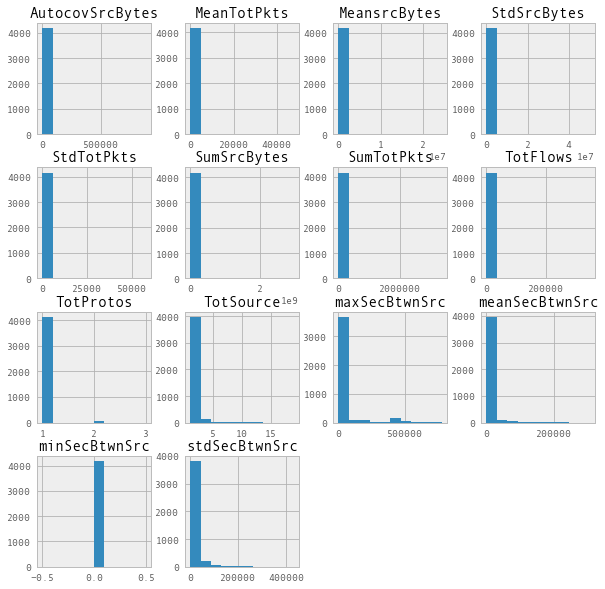

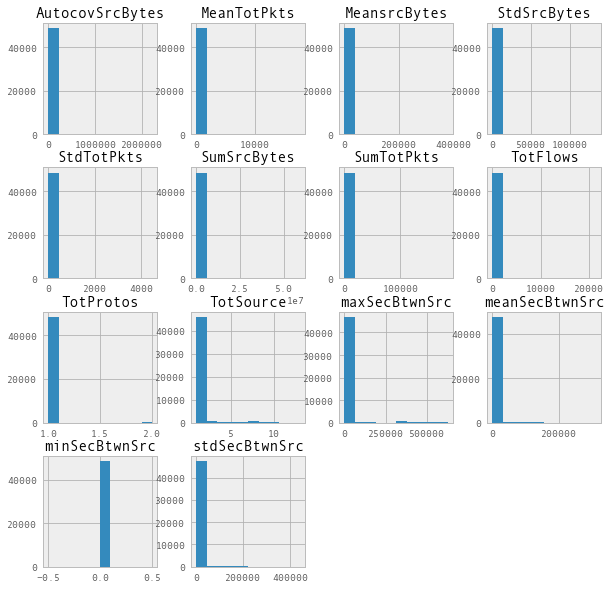

In [30]:
df_clean.drop(['DstAddr'], axis=1).groupby(['target']).hist(
    figsize=(10,10),
    sharex=False
)
plt.show()

TotFlows


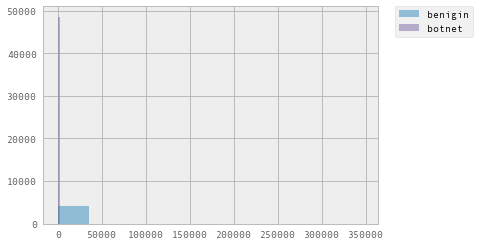

TotSource


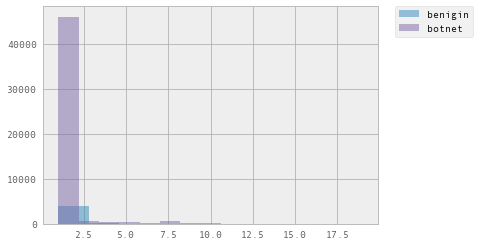

TotProtos


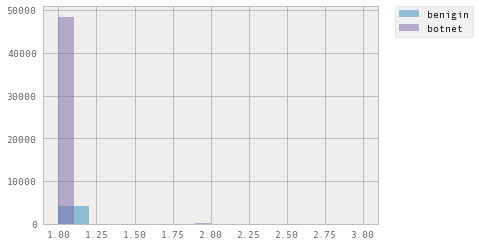

SumTotPkts


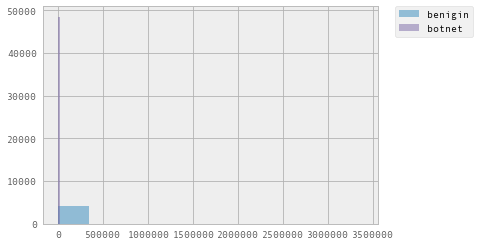

StdTotPkts


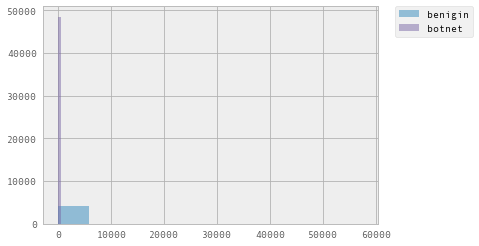

MeanTotPkts


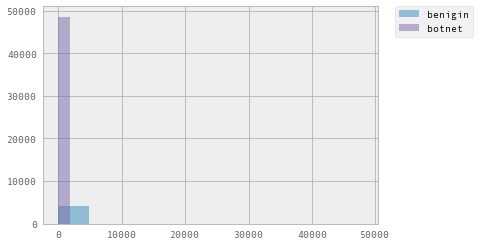

SumSrcBytes


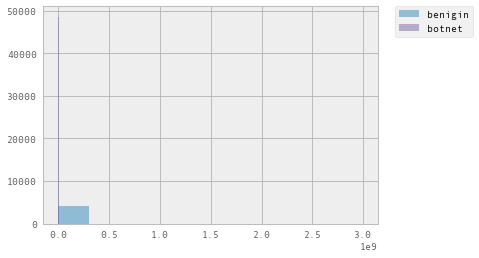

StdSrcBytes


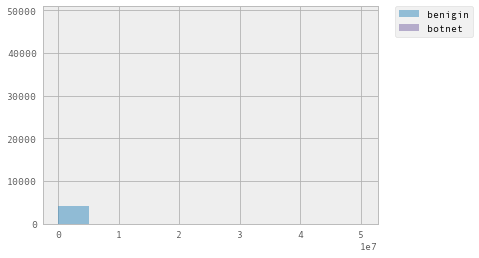

MeansrcBytes


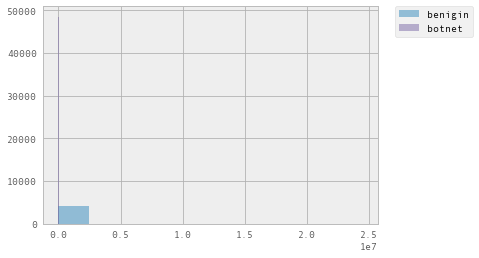

AutocovSrcBytes


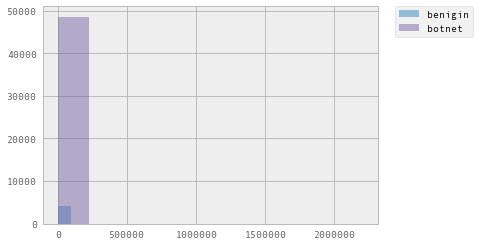

minSecBtwnSrc


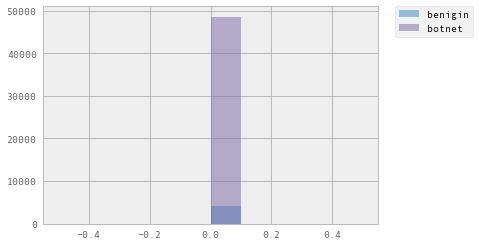

maxSecBtwnSrc


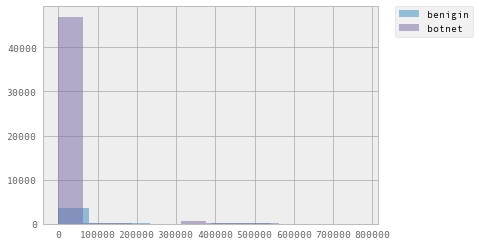

meanSecBtwnSrc


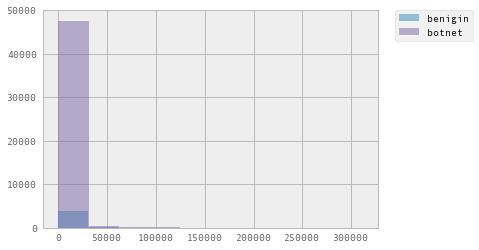

stdSecBtwnSrc


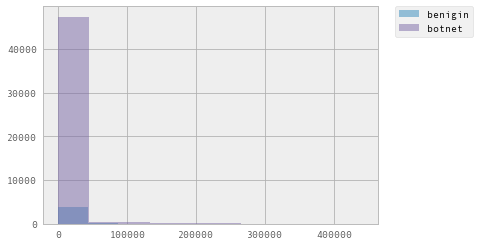

In [31]:
plot_df = df_clean.copy()
plot_df['target'] = plot_df['target'].replace({0: 'benigin', 1:'botnet'})
plot_df = plot_df.groupby('target')
labels = [name for name,group in plot_df]
fig, ax = plt.subplots()

for x in list(df_clean.drop(['DstAddr', 'target'], axis=1)):
    print(x)
    for k, v in plot_df[x]:
        v.hist(label=k, alpha=.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


# Classification

In [46]:
# Split our data
train, test, train_labels, test_labels = train_test_split(
    df_clean.drop(['target', 'DstAddr'], axis=1),
    df_clean['target'],
    test_size=0.33,
    random_state=42
)

## Decision Trees

In [47]:
# Initiate
dtree = tree.DecisionTreeClassifier()

# Train
model = dtree.fit(train, train_labels)

In [49]:
# Predct
preds = dtree.predict(test)

In [50]:
# Evaluate
print(accuracy_score(test_labels, preds))

0.98591954023


In [51]:
print("Number of mislabeled points out of a total %d points : %d"% (len(test),(test_labels != preds).sum()))

Number of mislabeled points out of a total 17400 points : 245


## Naive Bayes

In [33]:
#Initialize
gnb = GaussianNB()

# Train
model = gnb.fit(train, train_labels)

In [34]:
# Predict
preds = gnb.predict(test)

In [35]:
# Evaluate
print(accuracy_score(test_labels, preds))

0.910114942529


In [36]:
print("Number of mislabeled points out of a total %d points : %d"% (
    len(test),
    (test_labels != preds).sum())
)

Number of mislabeled points out of a total 17400 points : 1564


## KNN

In [37]:
# Initialize
knn = neighbors.KNeighborsClassifier()
model = knn.fit(train, train_labels)

In [38]:
# Predict
preds = knn.predict(test)

In [39]:
# Evaluate
print(accuracy_score(test_labels, preds))

0.979022988506


In [40]:
print("Number of mislabeled points out of a total %d points : %d"% (
    len(test),
    (test_labels != preds).sum())
)

Number of mislabeled points out of a total 17400 points : 365


## MLP (multi-layer perceptron)

In [41]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

scaler.fit(train)  
X_train = scaler.transform(train)  
# apply same transformation to test data
X_test = scaler.transform(test)  

In [70]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(100,2), random_state=1)

model = mlp.fit(X_train, train_labels)

In [71]:
preds = mlp.predict(X_test)

In [72]:
# Evaluate
print(accuracy_score(test_labels, preds))

0.925344827586


In [73]:
print("Number of mislabeled points out of a total %d points : %d"% (
    len(test),
    (test_labels != preds).sum())
)

Number of mislabeled points out of a total 17400 points : 1299


## SGD

In [113]:
sgd = SGDClassifier(loss="log", penalty="l2", tol=1e-3)

model = sgd.fit(X_train, train_labels)

In [114]:
preds = sgd.predict(X_test)

In [115]:
# Evaluate
print(accuracy_score(test_labels, preds))

0.912011494253


In [116]:
print("Number of mislabeled points out of a total %d points : %d"% (
    len(test),
    (test_labels != preds).sum())
)

Number of mislabeled points out of a total 17400 points : 1531


# Metrics

In [117]:
models = [
    (dtree, 'dtree'),
    (gnb,'gnb'),
    (knn, 'knn'),
    (mlp, 'mlp'),
    (sgd, 'sgd')
]

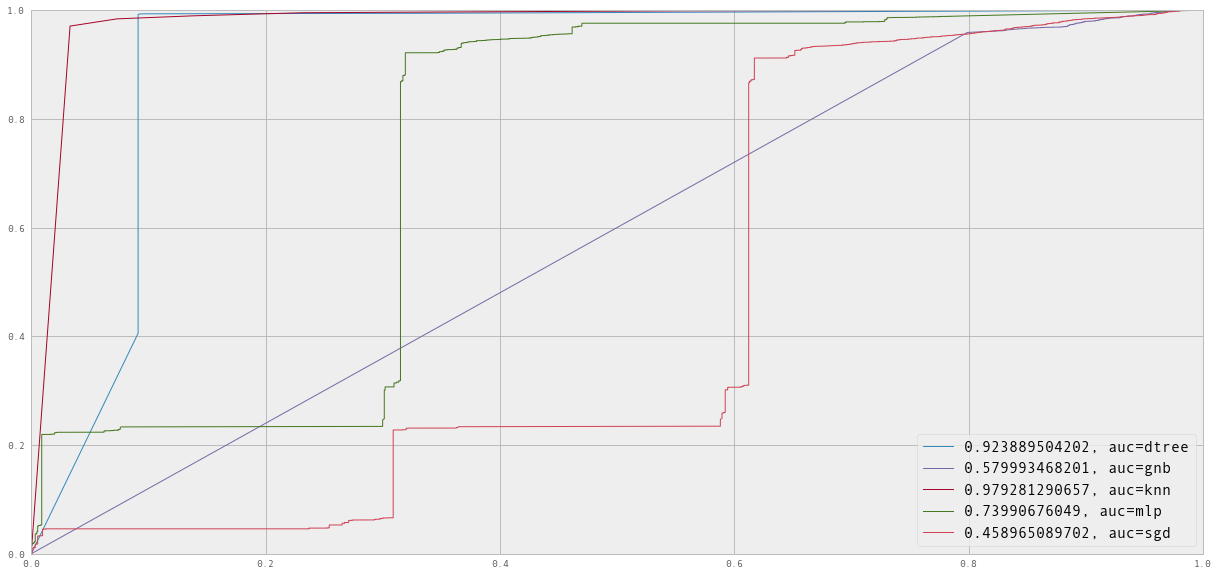

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(21,10))

for mod in models:
    if mod[1] in ['sgd', 'mlp']:
        preds = mod[0].predict_proba(X_test)[:,1]
    else:
        preds = mod[0].predict_proba(test)[:,1]
        
    fpr, tpr, _ = metrics.roc_curve(test_labels, preds)
    auc = metrics.roc_auc_score(test_labels, preds)
    plt.plot(fpr,tpr,label="%s, auc=%s"% (str(auc), str(mod[1])))
    plt.legend(loc=4)
plt.ylim(0, 1)
plt.xlim(0, 1)
ax.tick_params(axis='both', which='both', labelsize=10)
ax.legend(prop={'size':15})
plt.show()


# Report

Features were based on prior academic research on what features would help decipher botnet traffic from regular network traffic. 

This report used basic statistics like:
* Total number of flows to destination IP
* Total source IPs connecting to destination IP
* Total protocols to destination IP
* Total number of bytes to destination IP
* Mean number of bytes to destination IP
* Standard deviation of bytes to destination IP 
* Total number of packets to destination IP
* Mean number of packets to destination IP
* Standard deviation of bytes to destination IP

Higher level analyses like:
* Discrete autocovariance of bytes to destination IP
* Minimum time between source --> destination flows
* Maximum time between source --> destination flows
* Mean time between source --> destination flows
* Standard deviation of time between source --> destination flows

It is clear from graphing the distributions (histogram) of each feature for benign and botnet traffic that the behavior is _much_ different for every feature. We can see that botnet traffic is much more concentrated for some features like TotFlows and SumSrcBytes. The autocovariance of botnet traffic contains a range of much larger values - indicating repeating patterns in botnet traffic. Lastly, we see that botnets wait consistent amounts of time between connections, like maxSecBtwnSrc. We see that benign traffic covers a much larger range of values for this feature than botnet traffic. 

The classification performed was with five models. Decision trees, KNN, gaussian naive bayes, multi-layer perceptrons, and stochastic gradient descent classifiers. It could be expected that gaussian naive bayes would perform the worst in terms of ROC because this model assumes that the features can be represented as a gaussian distribution - which in this case, they most likely cannot. The decision trees and KNN perform the best. Lastly, the neural network models do not perform very well (but better than naive bayes) because perhaps there are too many factors to consider (i.e. the number of neurons, the solver), the data had to be fit to a scalar range, and there was no hyper parameter tuning or optimization.

Overall, if there was more time to continue this report, I would first explore more feature extracton labels. I would then do the same analysis (exploring benign and botnet traffic) with different graphs beyond the distribution plots above. Lastly, I would take one of the better performing models like KNN or decision trees and produce more performance metrics while also drilling down into its predicted results.